In [37]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_iris


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [38]:
tqdm.pandas()

In [39]:
df = pd.read_csv('../Datasets/Books_rating.csv')

In [40]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [41]:
df[['helpful_0', 'helpful_1']] = df['review/helpfulness'].str.split('/', expand=True)

# Konvertieren der 'helpfulness'-Spalte in numerische Werte (falls notwendig)
#df['review/helpfulness'] = pd.to_numeric(df['review/helpfulness'], errors='coerce')

df.head()


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,helpful_0,helpful_1
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,7,7
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,10,10
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",10,11
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,3,3


In [42]:
#df['helpful_0'] = df['helpful_0'].apply(func=lambda x: x*1)
#df['helpful_1'] = df['helpful_1'].apply(func=lambda x: x*1)

#### EDA v0

In [43]:
# Daten vor dem Plotten sortieren
df['helpful_0'] = df['helpful_0'].progress_apply(pd.to_numeric)
df['helpful_1'] = df['helpful_1'].progress_apply(pd.to_numeric)

  0%|          | 0/3000000 [00:00<?, ?it/s]

100%|██████████| 3000000/3000000 [00:42<00:00, 69819.10it/s]


In [44]:
df['helpful_0'] = df['helpful_0'].astype(int)
df['helpful_1'] = df['helpful_1'].astype(int)

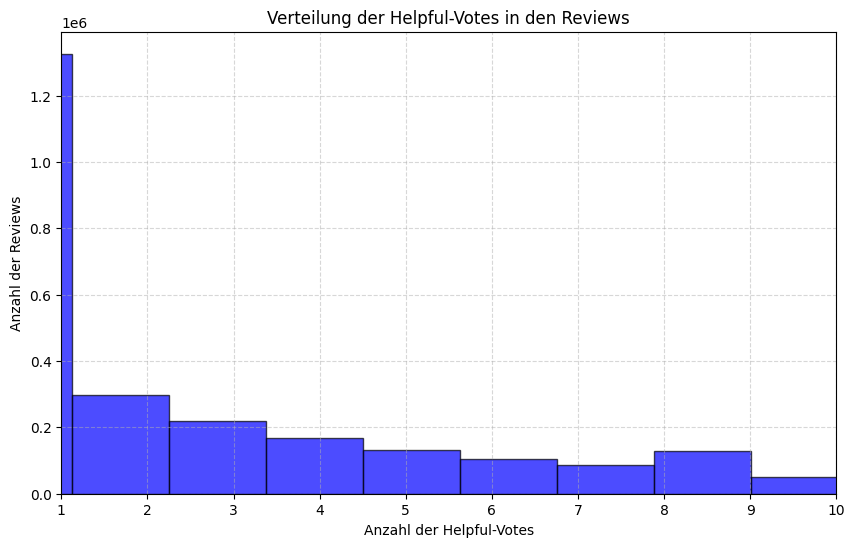

In [45]:
# Plot erstellen
plt.figure(figsize=(10, 6))


plt.hist(df['helpful_1'], bins=10000, color='blue', edgecolor='black', alpha=0.7)

# Titel und Beschriftungen hinzufügen
plt.title('Verteilung der Helpful-Votes in den Reviews')
plt.xlabel('Anzahl der Helpful-Votes')
plt.ylabel('Anzahl der Reviews')

# Gitter hinzufügen
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(1, 10)

# Diagramm anzeigen
plt.show()

In [46]:
num_rows = len(df[df['helpful_1'] >= 20])
print("Number of rows with helpful_1 > 3: ", num_rows)

Number of rows with helpful_1 > 3:  239553


In [47]:
# Remove reviews with not enough helpful votes
df = df[df['helpful_1'] >= 20]

In [48]:
df['helpful_ratio'] = df['helpful_0'] / df['helpful_1']


In [49]:
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,helpful_0,helpful_1,helpful_ratio,ratio_percent
47,0802841899,The Church of Christ: A Biblical Ecclesiology ...,25.97,ARI272XF8TOL4,Christopher J. Bray,74/81,5.0,955411200,Ecclesiological Milestone,With the publication of Everett Ferguson's boo...,74,81,0.913580,91
81,0974289108,The Ultimate Guide to Law School Admission: In...,14.95,A1KZ0RDJZQSY4O,sayock,27/29,3.0,1090368000,No &quot;Insider&quot; Secrets,If you are someone who is fairly new to the la...,27,29,0.931034,93
88,0809080699,The Repeal of Reticence: A History of America'...,NaN,A18YY5TBNSDW3O,Bartleby,29/29,5.0,899164800,Great treatment of the defeat of reticence by ...,"Using a quiet, restrained writing style that i...",29,29,1.000000,100
91,B000NKGYMK,Alaska Sourdough,NaN,NaN,NaN,36/37,5.0,949104000,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,0.972973,97
92,B000NKGYMK,Alaska Sourdough,NaN,AC58Z72OB2DDX,Gary W. Marian,29/30,5.0,945734400,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,0.966667,96


In [50]:
df.drop(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/time', 'review/summary'], axis='columns', inplace=True)

In [51]:
df.head()

,review/helpfulness,review/score,review/text,helpful_0,helpful_1,helpful_ratio,ratio_percent
47,74/81,5.0,With the publication of Everett Ferguson's boo...,74,81,0.913580,91
81,27/29,3.0,If you are someone who is fairly new to the la...,27,29,0.931034,93
88,29/29,5.0,"Using a quiet, restrained writing style that i...",29,29,1.000000,100
91,36/37,5.0,Ruth Allman has written an excellent book abou...,36,37,0.972973,97
92,29/30,5.0,"I have been using this book since 1988, the ei...",29,30,0.966667,96


In [52]:
df = df.rename(columns={"review/text":"Review","review/score": "Rating"})

df['review_len'] = [len(text.split()) for text in df.Review]
df.head()

,review/helpfulness,Rating,Review,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len
47,74/81,5.0,With the publication of Everett Ferguson's boo...,74,81,0.913580,91,999
81,27/29,3.0,If you are someone who is fairly new to the la...,27,29,0.931034,93,367
88,29/29,5.0,"Using a quiet, restrained writing style that i...",29,29,1.000000,100,532
91,36/37,5.0,Ruth Allman has written an excellent book abou...,36,37,0.972973,97,153
92,29/30,5.0,"I have been using this book since 1988, the ei...",29,30,0.966667,96,63


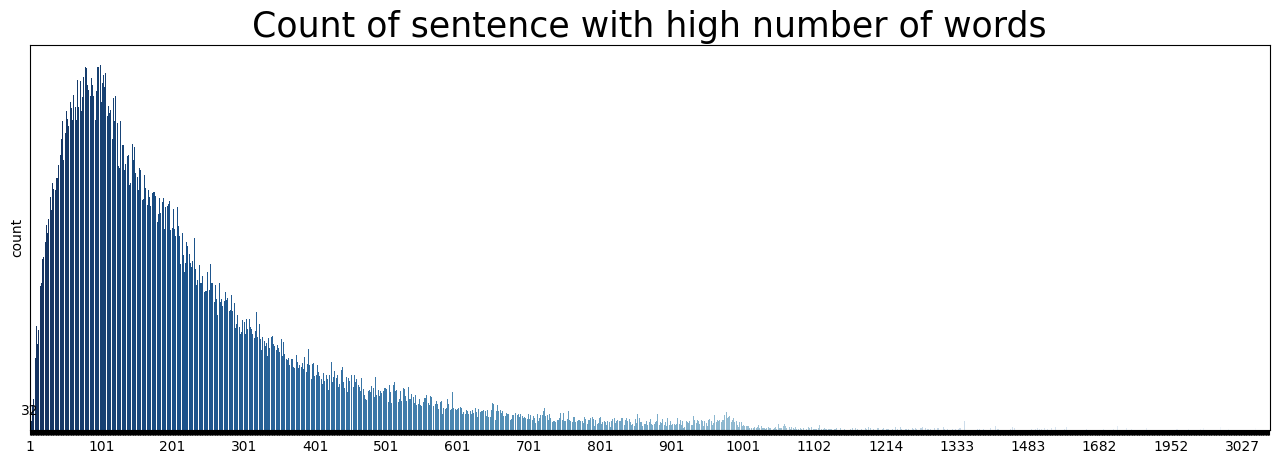

In [53]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='review_len', data=df, palette='Blues_r')
plt.title('Count of sentence with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')

# Reduziere die Anzahl der x-Achsenticks
n = 100  # Du kannst die Anzahl anpassen, um die Dichte der Ticks zu ändern
for i, label in enumerate(ax.get_xticklabels()):
    if i % n != 0:
        label.set_visible(False)

plt.show()

In [54]:
len(df)

239553

In [80]:
df = df[df['review_len'] <= 300]

In [81]:
len(df)

137055

In [82]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [83]:
df['IsHelpful'] = df.apply(convert_label, axis = 1)
df.head()

,review/helpfulness,Rating,Review,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,cleaned_reviews
34011,16/23,1.0,Tom Brokaw had as much to do with the writing ...,16,23,0.695652,69,300,0,tom brokaw much writing book king james i writ...
27583,68/71,5.0,"In Before You Think Another Thought, Bruce I. ...",68,71,0.957746,95,300,1,in before you think another thought bruce i do...
1929729,33/33,4.0,The critics focus on Lawrence's lifelong sexua...,33,33,1.000000,100,300,1,the critic focus lawrence lifelong sexual them...
1632480,20/20,4.0,Lauren Bennett had not become romantically inv...,20,20,1.000000,100,300,1,lauren bennett become romantically involved ma...
2632180,34/36,2.0,Mridula Baljekar's THE LOW-FAT INDIAN VEGETARI...,34,36,0.944444,94,300,1,mridula baljekars the lowfat indian vegetarian...


In [84]:
# Drop reviews below 10 words
#df = df[~(df['review_len'] < 10)]

In [85]:
df.sort_values(by='ratio_percent', ascending=False, inplace=True)
df.head()

,review/helpfulness,Rating,Review,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,cleaned_reviews
2144387,43/43,5.0,"Bill Shore uses stories from his life, as well...",43,43,1.0,100,147,1,bill shore us story life well famous famous ba...
2518180,33/33,5.0,I'm a 30 year old person that was born and rai...,33,33,1.0,100,187,1,im year old person born raised netherlands las...
227035,22/22,5.0,A friend recommended All Love Flows to the Sel...,22,22,1.0,100,187,1,a friend recommended all love flow self eterna...
1116593,26/26,4.0,This Disney song book is fun and easy to play....,26,26,1.0,100,85,1,this disney song book fun easy play it fake bo...
2993495,28/28,5.0,Until I read this book I never dreamed that th...,28,28,1.0,100,85,1,until i read book i never dreamed many creativ...


In [86]:
df.sort_values(by='review_len', ascending=False, inplace=True)
df.head()

,review/helpfulness,Rating,Review,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,cleaned_reviews
213761,26/29,5.0,When I passed the CCNA exam a year ago I used ...,26,29,0.896552,89,300,1,when i passed ccna exam year ago i used ccna s...
402877,22/23,5.0,This book is soooooo good. I read Pfanz Day On...,22,23,0.956522,95,300,1,this book soooooo good i read pfanz day one ma...
169861,35/47,3.0,"I have bought Missing Manuals before, and have...",35,47,0.744681,74,300,1,i bought missing manual pleased i think motto ...
998174,7/20,5.0,I work in the game industry and have done so f...,7,20,0.350000,35,300,0,i work game industry done year i mainly create...
2145491,20/40,3.0,THIS IS A BOOK THAT MUST BE RECOMMENDED. IT MA...,20,40,0.500000,50,300,0,this is a book that must be recommended it may...


### Data Prepossessing :ghost:

In [87]:
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

In [88]:
df['cleaned_reviews'] = df['Review'].progress_apply(DataPrep)

100%|██████████| 137055/137055 [02:12<00:00, 1031.60it/s]


In [89]:
df.head()

,review/helpfulness,Rating,Review,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,cleaned_reviews
213761,26/29,5.0,When I passed the CCNA exam a year ago I used ...,26,29,0.896552,89,300,1,when i passed ccna exam year ago i used ccna s...
402877,22/23,5.0,This book is soooooo good. I read Pfanz Day On...,22,23,0.956522,95,300,1,this book soooooo good i read pfanz day one ma...
169861,35/47,3.0,"I have bought Missing Manuals before, and have...",35,47,0.744681,74,300,1,i bought missing manual pleased i think motto ...
998174,7/20,5.0,I work in the game industry and have done so f...,7,20,0.350000,35,300,0,i work game industry done year i mainly create...
2145491,20/40,3.0,THIS IS A BOOK THAT MUST BE RECOMMENDED. IT MA...,20,40,0.500000,50,300,0,this is a book that must be recommended it may...


In [90]:
print(f'There are around {int(df["cleaned_reviews"].duplicated().sum())} duplicated reviews, we will remove them.')

There are around 0 duplicated reviews, we will remove them.


In [91]:
df.drop_duplicates("cleaned_reviews", inplace=True)

### EDA

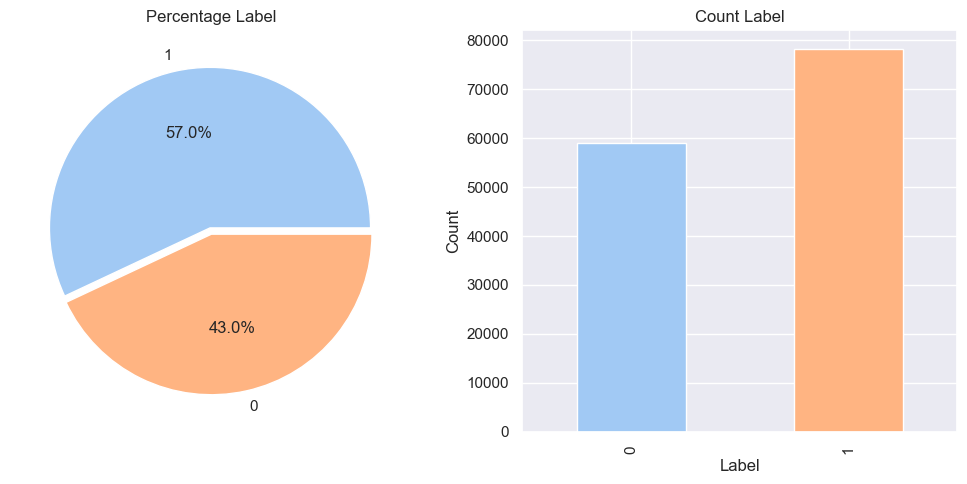

In [92]:
label_count = df['IsHelpful'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

#sns.countplot(df['Rating'] , ax=axes[1])
counts = df['IsHelpful'].value_counts().sort_index()
counts.plot.bar(color=color)
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Split Data

In [93]:
#iris = load_iris()
x_train, x_val, y_train, y_val = train_test_split(df['cleaned_reviews'], df['IsHelpful'], train_size=0.80, random_state=42)

In [94]:
len(x_train), len(x_val)

(109644, 27411)

### Feature Extraction

In [97]:
# Options: max_features=50000, min_df=5, ngram_range=(1,2)
vec = TfidfVectorizer(max_features=25000)
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names_out()))

No. of feature words:  25000


In [98]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

In [99]:
# Batch-Verarbeitung für Trainingsdaten

"""
batch_size = 1  # Ändere dies entsprechend deinem Speicherplatz
num_batches_train = int(np.ceil(len(x_train) / batch_size))

X_train_combined = None

for i in range(num_batches_train):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    texts_train_batch = x_train[start_idx:end_idx]
    X_train_batch = vec.transform(texts_train_batch).toarray()

    if X_train_combined is None:
        X_train_combined = X_train_batch
    else:
        X_train_combined = np.vstack((X_train_combined, X_train_batch))

# Logistic Regression-Modell erstellen und anpassen
model = LogisticRegression(random_state=42)
model.fit(X_train_combined, y_train)

# Batch-Verarbeitung für Testdaten
num_batches_test = int(np.ceil(len(x_val) / batch_size))

X_test_combined = None

for i in range(num_batches_test):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    texts_test_batch = x_val[start_idx:end_idx]
    X_test_batch = vec.transform(texts_test_batch).toarray()

    if X_test_combined is None:
        X_test_combined = X_test_batch
    else:
        X_test_combined = np.vstack((X_test_combined, X_test_batch))

# Vorhersagen treffen und Genauigkeit berechnen
y_pred = model.predict(X_test_combined)
accuracy = accuracy_score(y_val, y_pred)

print("Genauigkeit:", accuracy)
"""

'\nbatch_size = 1  # Ändere dies entsprechend deinem Speicherplatz\nnum_batches_train = int(np.ceil(len(x_train) / batch_size))\n\nX_train_combined = None\n\nfor i in range(num_batches_train):\n    start_idx = i * batch_size\n    end_idx = (i + 1) * batch_size\n    texts_train_batch = x_train[start_idx:end_idx]\n    X_train_batch = vec.transform(texts_train_batch).toarray()\n\n    if X_train_combined is None:\n        X_train_combined = X_train_batch\n    else:\n        X_train_combined = np.vstack((X_train_combined, X_train_batch))\n\n# Logistic Regression-Modell erstellen und anpassen\nmodel = LogisticRegression(random_state=42)\nmodel.fit(X_train_combined, y_train)\n\n# Batch-Verarbeitung für Testdaten\nnum_batches_test = int(np.ceil(len(x_val) / batch_size))\n\nX_test_combined = None\n\nfor i in range(num_batches_test):\n    start_idx = i * batch_size\n    end_idx = (i + 1) * batch_size\n    texts_test_batch = x_val[start_idx:end_idx]\n    X_test_batch = vec.transform(texts_test_ba

In [100]:
x_train.shape , x_val.shape

((109644, 25000), (27411, 25000))

In [115]:
# Add 'len' feature to the TF-IDF transformed data
#x_train_combined = np.column_stack((x_train, len_train))
#x_val_combined = np.column_stack((x_val, len_val))

In [101]:
#print(x_train_combined)

In [102]:
#x_train_combined.shape, x_val_combined.shape

### Logistic Regret

### LR mit Review+IsHelpful

In [103]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [104]:
train_acc1 = lr.score(x_train , y_train)

In [105]:
lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred) 

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

In [106]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 82.97%

The validation accuracy for logistic regression : 79.21%

The precision for logistic regression : 0.79

The recall for logistic regression : 0.79

The f1 score for logistic regression : 0.79



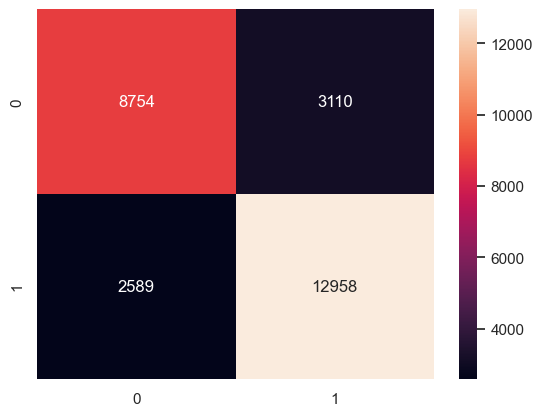

In [107]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

### AB HIER WURDE NOCH NICHT WEITER AUSGEFÜHRT SEIT NEUEM DATENSATZ

In [143]:
def predict_helpfulness(review_text):
    # Vorverarbeitung des Texts (Tokenisierung, etc.)
    preprocessed_text = DataPrep(review_text)  # Du müsstest deine eigene Vorverarbeitungsfunktion implementieren

    # Umwandlung des vorverarbeiteten Texts in TF-IDF-Merkmale
    tfidf_features = vec.transform([preprocessed_text])

    # Vorhersage mit dem trainierten Logistic Regression-Modell
    prediction = lr.predict(tfidf_features)

    return prediction[0]

In [155]:
predict_helpfulness("Con: Christmas on the 24th of September. Pro: I love christmas!")

0

### LR mit Review+IsHelpful+Len

In [123]:
# Model mit review_len
lr1 = LogisticRegression(random_state=42)
lr1.fit(x_train_combined, y_train)

LogisticRegression(random_state=42)

In [124]:
train_acc1_2 = lr1.score(x_train_combined , y_train)

In [125]:
lr1_pred = lr1.predict(x_val_combined)

val_acc1_2 = accuracy_score(y_val , lr1_pred) 

val_precision1_2 = precision_score(y_val , lr1_pred , average='weighted')
val_recall1_2 = recall_score(y_val , lr1_pred , average='weighted')
val_f1score1_2 = f1_score(y_val , lr1_pred , average='weighted')

In [126]:
print(f"The training accuracy for logistic regression : {(train_acc1_2*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1_2*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1_2:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1_2:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1_2:0.2f}\n")

The training accuracy for logistic regression : 79.03%

The validation accuracy for logistic regression : 75.85%

The precision for logistic regression : 0.73

The recall for logistic regression : 0.76

The f1 score for logistic regression : 0.70



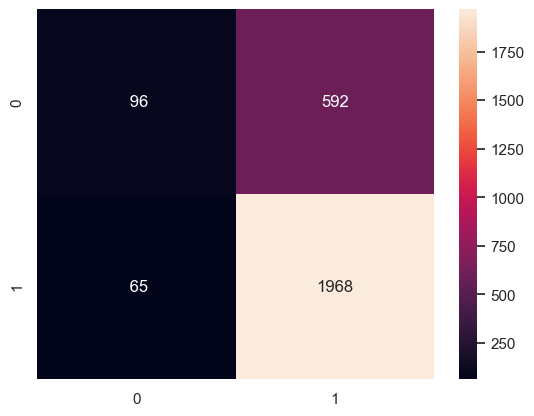

In [127]:
lr1_cm = confusion_matrix(y_val , lr1_pred)
sns.heatmap(lr1_cm, annot=True,fmt='3g')
plt.show()